In [1]:
# imports
import tueplots
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import isfile



In [2]:
# Constants
ENTITY = "ima-vae"
PROJECT = "priors"
SWEEP_ID = "djnaq95k"


In [3]:
api = wandb.Api(timeout=200)
runs = api.runs(ENTITY + "/" + PROJECT)

sweep = api.sweep(f"{ENTITY}/{PROJECT}/{SWEEP_ID}")
sweep_runs = sweep.runs

In [5]:
summary_list, config_list, name_list, sigmas = [], [], [], []
filename = "moebius_sweep_data.csv"
if not isfile(filename):
    for run in sweep_runs:

        if run.state != 'failed' and f'Metrics/val/latent_statistics.latent_variance_0' in run.history().keys():

            # .summary contains the output keys/values for metrics like accuracy.
            #  We call ._json_dict to omit large files
            summary_list.append(run.summary._json_dict)



            # .config contains the hyperparameters.
            #  We remove special values that start with _.
            config_list.append(
                {k: v for k,v in run.config.items()
                 if not k.startswith('_')})

            sigmas.append(run.history(keys=[f'Metrics/val/latent_statistics.latent_variance_{i}' for i in range(config_list[-1]['latent_dim'])]).iloc[-1].to_numpy()[1:])


            # .name is the human-readable name of the run.
            name_list.append(run.name)



    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list,
        "sigmas" : sigmas
        })

    runs_df.to_csv(filename)
else:
    runs_df = pd.read_csv(filename)

In [6]:
data = [ (summary['Metrics/val/mcc'], summary['Metrics/val/cima'], config['latent_dim'], config['decoder_var'], config['model.prior'],summary['Metrics/val/col_norms'], sigma) for summary, config, sigma in zip(runs_df['summary'], runs_df['config'], runs_df['sigmas'])]

$$ \sigma_k^2 (x) = \left(-n''(\mu_k^\phi(x)) + \gamma^2 \left\Vert \left[ J_f(g(x))\right]_{:k}\right\Vert^2\right)^{-1} $$

In [7]:
gamma_sq = [np.array(1./d[3]) for d in data]
prior = [d[4] for d in data]
col_norm_sq = [np.power(d[5],2) for d in data]
sigmas = runs_df.sigmas.to_numpy()
mcc = np.array([d[0] for d in data])
cima = np.array([d[1] for d in data])
dim = np.array([d[2] for d in data])

In [8]:
ext_gamma_sq = [g*np.ones((d, 1)) for g,d in zip(gamma_sq, dim)]

In [9]:
lhs_gauss = [s for s,p in zip(sigmas,prior) if p == "gaussian"]
rhs_gauss = [1./(1+g*J) for g, J, p in zip(gamma_sq, col_norm_sq, prior) if p == "gaussian"]
gamma_gauss = [g for g,p in zip(ext_gamma_sq, prior) if p == "gaussian"]

lhs_laplace = [s for s,p in zip(sigmas,prior) if p == "laplace"]
rhs_laplace = [1./(g*J) for g, J, p in zip(gamma_sq, col_norm_sq, prior) if p == "laplace"]
gamma_laplace = [g for g,p in zip(ext_gamma_sq, prior) if p == "laplace"]

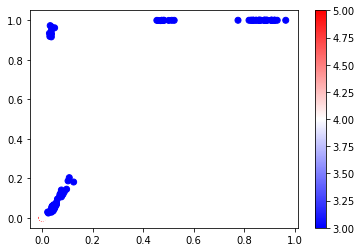

In [10]:
plt.scatter(np.concatenate(lhs_gauss), np.concatenate(rhs_gauss), c=np.log10(np.concatenate(gamma_gauss)), cmap='bwr', )
plt.colorbar()

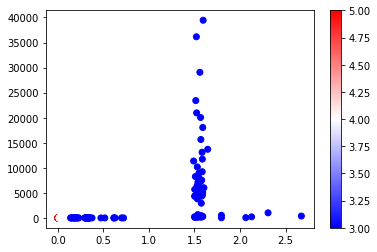

In [11]:
plt.scatter(np.concatenate(lhs_laplace), np.concatenate(rhs_laplace), c=np.log10(np.concatenate(gamma_laplace)), cmap='bwr',)
plt.colorbar()

Text(0, 0.5, 'gamma_sq')

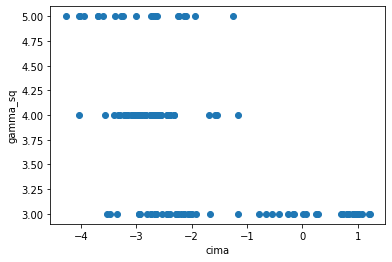

In [12]:
plt.scatter(np.log10(cima), np.log10(gamma_sq))
plt.xlabel('cima')
plt.ylabel('gamma_sq')

Text(0, 0.5, 'gamma_sq')

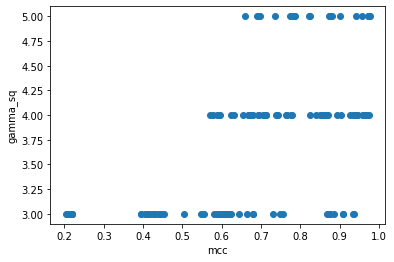

In [13]:
plt.scatter(mcc, np.log10(gamma_sq))
plt.xlabel('mcc')
plt.ylabel('gamma_sq')

In [14]:
cima_vs_dim = [ np.array([c for d, c in zip(dim, cima) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]
mcc_vs_dim = [ np.array([m for d, m in zip(dim, mcc) if d==dim_select]) for dim_select in np.unique(np.array(dim))  ]

{'bodies': [<matplotlib.collections.PolyCollection at 0x11c883df0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11c84a0a0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11c89be20>,
 'cbars': <matplotlib.collections.LineCollection at 0x11c8aa220>}

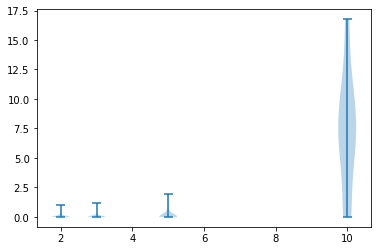

In [15]:
plt.violinplot(cima_vs_dim, positions=np.unique(np.array(dim)))

{'bodies': [<matplotlib.collections.PolyCollection at 0x11c918250>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x11c8b3dc0>,
 'cmins': <matplotlib.collections.LineCollection at 0x11c9271f0>,
 'cbars': <matplotlib.collections.LineCollection at 0x11c9275b0>}

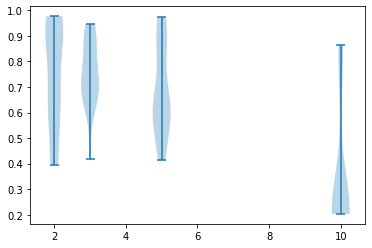

In [16]:
plt.violinplot(mcc_vs_dim, positions=np.unique(np.array(dim)))

Text(0, 0.5, 'mcc')

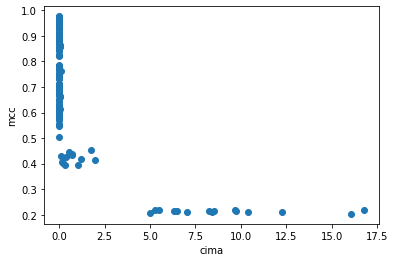

In [17]:
plt.scatter(cima, mcc)
plt.xlabel("cima")
plt.ylabel("mcc")